### Student Information
Name: Angeline Aurelia Waly

Student ID: 110006216

GitHub ID: angelineaurelia

Kaggle name: Angeline Aurelia

Kaggle private scoreboard snapshot: 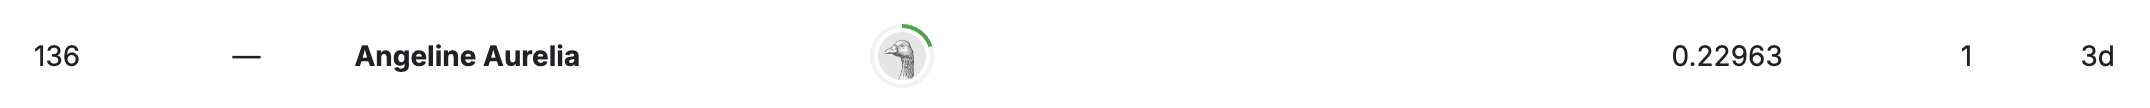

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

### Setting Up the Notebook

#### Import Necessaries Library

In [ ]:
### Begin Assignment Here
import json
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#### Load and prepare the data

In [ ]:
# Read data from JSON file
data_path = '/Users/angelineaurelia/Downloads/dm-2024-isa-5810-lab-2-homework/tweets_DM.json'
with open(data_path, 'r') as file:
    data = [json.loads(line) for line in file]

# Load CSV files
emotion_path = '/Users/angelineaurelia/Downloads/dm-2024-isa-5810-lab-2-homework/emotion.csv'
data_identification_path = '/Users/angelineaurelia/Downloads/dm-2024-isa-5810-lab-2-homework/data_identification.csv'
emotion_df = pd.read_csv(emotion_path)
data_identification_df = pd.read_csv(data_identification_path)

In [ ]:
# Extract data from nested dictionary and create a DataFrame
df = pd.DataFrame({
    'tweet_id': [item['_source']['tweet']['tweet_id'] for item in data],
    'hashtags': [item['_source']['tweet']['hashtags'] for item in data],
    'text': [item['_source']['tweet']['text'] for item in data]
})

In [ ]:
# Merge the DataFrame with the identification and emotion data
df = df.merge(data_identification_df, on='tweet_id', how='left')
train_data = df[df['identification'] == 'train']
train_data = train_data.merge(emotion_df, on='tweet_id', how='left')

### Data Preprocessing

In [ ]:
# Remove duplicate tweets based on text content
train_data.drop_duplicates(subset=['text'], keep='first', inplace=True)

In [ ]:
# Sampling the data to reduce the size
train_data_sample = train_data.sample(frac=0.1, random_state=42) 

In [ ]:
import re
import spacy
from textblob import TextBlob

# Load spaCy model for English
nlp = spacy.load('en_core_web_sm')

def expand_contractions(text):
    # Dictionary of English contractions
    contractions_dict = {"can't": "cannot", "won't": "will not", "n't": " not", "'re": " are", "'s": " is", "'d": " would", "'ll": " will",
                         "'t": " not", "'ve": " have", "'m": " am"}
    contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

    def replace(match):
        return contractions_dict[match.group(0)]
    
    return contractions_re.sub(replace, text)

def remove_special_characters(text, remove_digits=False):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove everything that is not letters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def correct_spellings(text):
    return str(TextBlob(text).correct())

def preprocess_text(row):
    text = row['text'] + ' ' + ' '.join(row['hashtags'])
    text = expand_contractions(text)
    text = text.lower()
    text = remove_special_characters(text, remove_digits=True)
    text = correct_spellings(text)
    doc = nlp(text)
    adjectives = [token.text for token in doc if token.pos_ == 'ADJ']
    return ' '.join(adjectives)

In [ ]:
# Apply preprocessing to train data
train_data_sample['processed_text'] = train_data_sample.apply(preprocess_text, axis=1)

In [ ]:
# Remove entries without adjectives as they won't be useful for our model
train_data_sample = train_data_sample[train_data_sample['processed_text'] != '']

In [ ]:
# Prepare features and labels
X_train = train_data_sample['processed_text']
y_train = train_data_sample['emotion']

In [ ]:
# Encode the labels to be used in the model
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)

In [ ]:
# Using TF-IDF Vectorizer to convert text data into TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [ ]:
# Use a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train)

In [ ]:
# Prediction and Evaluation
y_pred = random_forest_model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

### Prepare and Predict on Test Data

In [ ]:
# Identify and prepare the test dataset
test_data = df[df['identification'] == 'test']

In [ ]:
# Preprocess the text data in the test dataset
test_data.loc[:, 'processed_text'] = test_data.apply(preprocess_text, axis=1)

# Convert test data text to TF-IDF features using the same vectorizer trained on the training data
X_test_data = tfidf_vectorizer.transform(test_data['processed_text']).toarray()

# Predict the emotions on the test dataset using the trained model
y_test_pred = random_forest_model.predict(X_test_data)

In [ ]:
# Convert predicted numeric labels back to original emotion labels
predicted_emotions = label_encoder.inverse_transform(y_test_pred)

# Create a DataFrame for the submission, mapping tweet IDs to predicted emotions
submission = pd.DataFrame({
    'id': test_data['tweet_id'],
    'emotion': predicted_emotions
})

### Output the submission file

In [ ]:
# Output the submission file
submission.to_csv('/kaggle/working/submission.csv', index=False)